# -*- coding: utf-8 -*-
"""
Detailed Exploration of Historical Traffic Status Data

This notebook loads and analyzes a single monthly historical traffic CSV file 
downloaded from the 'trams' dataset on Open Data BCN.
"""

In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

In [2]:
# --- Configuration ---
DATA_DIR = "../data/raw/traffic_history" 
TRAFFIC_CSV_FILENAME = "2024_12_Desembre_TRAMS_TRAMS.csv" 
TRAFFIC_CSV_FILE = os.path.join(DATA_DIR, TRAFFIC_CSV_FILENAME)

In [3]:
# --- Load Data ---
print(f"Loading data from: {TRAFFIC_CSV_FILE}")
if os.path.exists(TRAFFIC_CSV_FILE):
    try:
        # Load using comma separator and first row as header
        df_traffic = pd.read_csv(TRAFFIC_CSV_FILE, sep=',', header=0, on_bad_lines='warn')
        
        # Rename columns for consistency
        rename_map = {
             'idTram': 'ID_TRAM', 
             'data': 'DataHoraLectura', 
             'estatActual': 'EstatActual', 
             'estatPrevist': 'PrevisioActual' 
        }
        df_traffic.rename(columns=rename_map, inplace=True)
        
        print(f"Loaded {len(df_traffic)} rows successfully.")
        
    except Exception as e:
        print(f"Error loading CSV file: {e}")
        df_traffic = pd.DataFrame() # Create empty df if loading fails
else:
    print(f"Error: File not found at {TRAFFIC_CSV_FILE}")
    print("Please ensure the data ingestion script ran successfully and downloaded the file.")
    df_traffic = pd.DataFrame()


Loading data from: ../data/raw/traffic_history/2024_12_Desembre_TRAMS_TRAMS.csv
Loaded 1982764 rows successfully.


In [4]:
# --- Initial Inspection & Datetime Conversion ---
if not df_traffic.empty:
    print("\n--- DataFrame Info (Initial) ---")
    df_traffic.info()

    print("\n--- First 5 Rows ---")
    print(df_traffic.head())

    # Convert DataHoraLectura to datetime
    print("\n--- Converting 'DataHoraLectura' to datetime ---")
    try:
        # Use the correct format string based on example 20241201000553
        df_traffic['Timestamp'] = pd.to_datetime(df_traffic['DataHoraLectura'], format='%Y%m%d%H%M%S', errors='coerce')
        # Drop rows where conversion failed
        rows_before = len(df_traffic)
        df_traffic.dropna(subset=['Timestamp'], inplace=True)
        rows_after = len(df_traffic)
        if rows_before > rows_after:
            print(f"Warning: Dropped {rows_before - rows_after} rows due to invalid datetime format.")
        
        # Optional: Drop the original string column if no longer needed
        # df_traffic.drop(columns=['DataHoraLectura'], inplace=True)
        
        print("Datetime conversion successful. New 'Timestamp' column added.")
        print("\n--- DataFrame Info (After Datetime Conversion) ---")
        df_traffic.info()
        print("\n--- Head with Timestamp ---")
        print(df_traffic[['ID_TRAM', 'Timestamp', 'EstatActual', 'PrevisioActual']].head())
        
        # Check time range
        print(f"\nTime range in this file: {df_traffic['Timestamp'].min()} to {df_traffic['Timestamp'].max()}")
        
    except KeyError:
         print("Error: Column 'DataHoraLectura' not found for conversion.")
    except Exception as e:
        print(f"An error occurred during datetime conversion: {e}")
        
else:
    print("\nDataFrame is empty, skipping analysis.")

# --- TODO: Further Analysis (in subsequent cells) ---
# 1. Analyze 'EstatActual' (Traffic Status)
#    - Value counts (focus on 0 and 6)
#    - Distribution plot
#    - Meaning of values (1=Fluid ... 5=Congested?, 0=NoData?, 6=Blocked?)
# 2. Analyze 'PrevisioActual' (Forecast)
#    - Value counts
#    - Relationship with 'EstatActual' (e.g., confusion matrix, time-shifted correlation?)
# 3. Analyze Update Frequency
#    - Group by 'ID_TRAM'
#    - Calculate time differences between consecutive 'Timestamp' entries for each tram
#    - Check if it's consistently around 5 minutes.
# 4. Analyze specific TRAMs over time.

print("\n--- End of Initial Loading and Datetime Conversion ---")



--- DataFrame Info (Initial) ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1982764 entries, 0 to 1982763
Data columns (total 4 columns):
 #   Column           Dtype
---  ------           -----
 0   ID_TRAM          int64
 1   DataHoraLectura  int64
 2   EstatActual      int64
 3   PrevisioActual   int64
dtypes: int64(4)
memory usage: 60.5 MB

--- First 5 Rows ---
   ID_TRAM  DataHoraLectura  EstatActual  PrevisioActual
0        1   20241201000553            1               0
1        2   20241201000553            0               0
2        3   20241201000553            0               0
3        4   20241201000553            0               0
4        5   20241201000553            0               0

--- Converting 'DataHoraLectura' to datetime ---
Datetime conversion successful. New 'Timestamp' column added.

--- DataFrame Info (After Datetime Conversion) ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1982764 entries, 0 to 1982763
Data columns (total 5 columns):
 #   Co


--- Analysis of 'EstatActual' ---

Value Counts for EstatActual:
EstatActual
0    915715
1    380717
2    536676
3     92417
4     35685
5     17484
6      4070
Name: count, dtype: int64

Percentage Distribution for EstatActual:
EstatActual
0    46.18%
1     19.2%
2    27.07%
3     4.66%
4      1.8%
5     0.88%
6     0.21%
Name: proportion, dtype: object

Plotting Distribution of EstatActual:


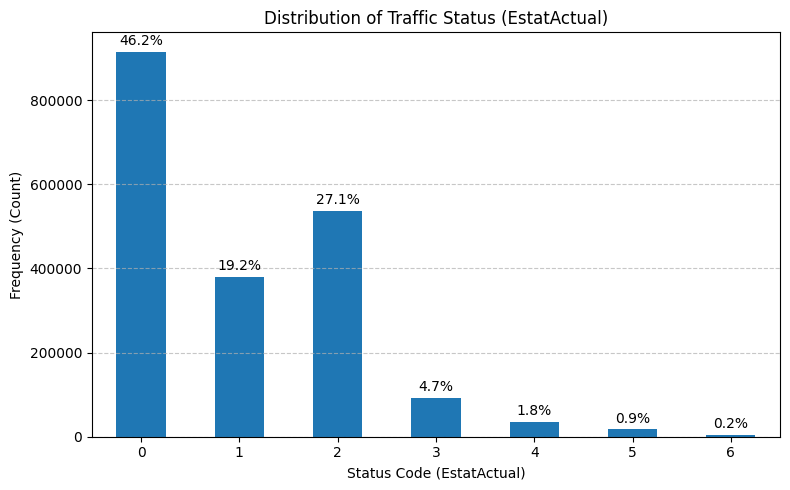


Interpretation Guide (based on documentation/common use):
  0: No Data / Unknown
  1: Very Fluid
  2: Fluid
  3: Dense
  4: Very Dense / Congested
  5: Congestion / Gridlock
  6: Cut / Blocked
Note: Value 0 is most frequent, indicating periods/sensors with no data.
Note: Value 6 (Cut/Blocked) is present.


In [5]:
# --- 1. Analyze EstatActual (Traffic Status) ---
if not df_traffic.empty and 'EstatActual' in df_traffic.columns:
    print("\n--- Analysis of 'EstatActual' ---")
    
    print("\nValue Counts for EstatActual:")
    estat_counts = df_traffic['EstatActual'].value_counts().sort_index()
    print(estat_counts)
    
    # Calculate percentages
    print("\nPercentage Distribution for EstatActual:")
    estat_percentages = df_traffic['EstatActual'].value_counts(normalize=True).sort_index() * 100
    print(estat_percentages.round(2).astype(str) + '%')

    # Plot distribution
    print("\nPlotting Distribution of EstatActual:")
    try:
        plt.figure(figsize=(8, 5))
        # Use the counts for the bar plot heights
        estat_counts.plot(kind='bar', rot=0) 
        plt.title('Distribution of Traffic Status (EstatActual)')
        plt.xlabel('Status Code (EstatActual)')
        plt.ylabel('Frequency (Count)')
        # Annotate bars with percentage
        for index, value in enumerate(estat_counts):
             perc = estat_percentages.iloc[index]
             plt.text(index, value + (estat_counts.max()*0.01) , f'{perc:.1f}%', ha='center', va='bottom') # Adjust position slightly
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"Could not plot distribution: {e}")
        
    print("\nInterpretation Guide (based on documentation/common use):")
    print("  0: No Data / Unknown")
    print("  1: Very Fluid")
    print("  2: Fluid")
    print("  3: Dense")
    print("  4: Very Dense / Congested")
    print("  5: Congestion / Gridlock")
    print("  6: Cut / Blocked")
    print("Note: Value 0 is most frequent, indicating periods/sensors with no data.")
    if 6 in estat_counts.index:
        print("Note: Value 6 (Cut/Blocked) is present.")

else:
    print("\nSkipping EstatActual analysis: DataFrame empty or column missing.")


--- Analysis of 'PrevisioActual' ---

Value Counts for PrevisioActual:
PrevisioActual
0    1039155
1     340309
2     425351
3     112489
4      40612
5      20778
6       4070
Name: count, dtype: int64

Percentage Distribution for PrevisioActual:
PrevisioActual
0    52.41%
1    17.16%
2    21.45%
3     5.67%
4     2.05%
5     1.05%
6     0.21%
Name: proportion, dtype: object

Plotting Distribution of PrevisioActual:


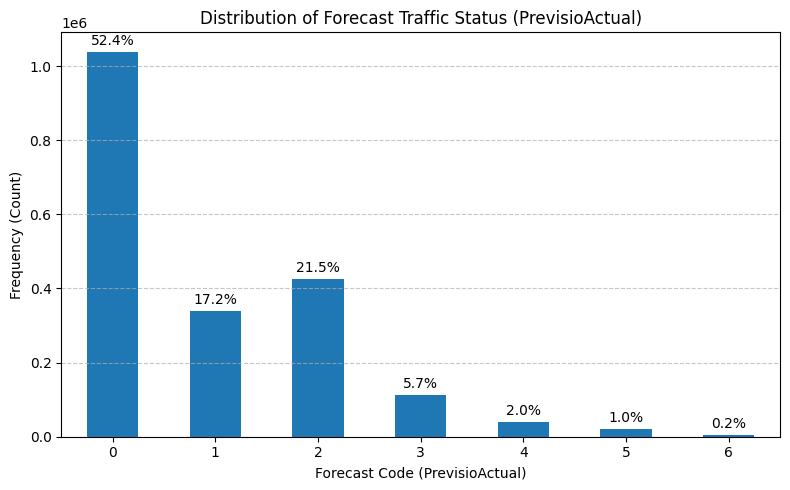


Cross-tabulation: PrevisioActual vs EstatActual (Sample)
EstatActual        0    1    2    3   4   5   6
PrevisioActual                                 
0               2307  127  195    2   1   1   0
1                  0  736  129    7   3   0   0
2                  0  115  923   58   6   1   0
3                  0    8  104  109  20   1   0
4                  0    2   16   34  42   4   0
5                  0    5    1    3   9  26   0
6                  0    0    0    0   0   0  10
(Note: Crosstab based on a sample of the data)


In [6]:
# --- 2. Analyze PrevisioActual (Forecast Status) ---
if not df_traffic.empty and 'PrevisioActual' in df_traffic.columns:
    print("\n--- Analysis of 'PrevisioActual' ---")
    
    print("\nValue Counts for PrevisioActual:")
    previsio_counts = df_traffic['PrevisioActual'].value_counts().sort_index()
    print(previsio_counts)
    
    print("\nPercentage Distribution for PrevisioActual:")
    previsio_percentages = df_traffic['PrevisioActual'].value_counts(normalize=True).sort_index() * 100
    print(previsio_percentages.round(2).astype(str) + '%')

    # Plot distribution (similar to EstatActual)
    print("\nPlotting Distribution of PrevisioActual:")
    try:
        plt.figure(figsize=(8, 5))
        previsio_counts.plot(kind='bar', rot=0)
        plt.title('Distribution of Forecast Traffic Status (PrevisioActual)')
        plt.xlabel('Forecast Code (PrevisioActual)')
        plt.ylabel('Frequency (Count)')
        for index, value in enumerate(previsio_counts):
             perc = previsio_percentages.iloc[index]
             plt.text(index, value + (previsio_counts.max()*0.01) , f'{perc:.1f}%', ha='center', va='bottom')
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"Could not plot distribution: {e}")
        
    # Optional: Cross-tabulation to see relationship with EstatActual
    if 'EstatActual' in df_traffic.columns:
        print("\nCross-tabulation: PrevisioActual vs EstatActual (Sample)")
        # Sample to avoid huge crosstab
        sample_size = min(100000, len(df_traffic)) 
        crosstab_sample = pd.crosstab(
            df_traffic.sample(sample_size)['PrevisioActual'], 
            df_traffic.sample(sample_size)['EstatActual']
        )
        print(crosstab_sample)
        print("(Note: Crosstab based on a sample of the data)")

else:
    print("\nSkipping PrevisioActual analysis: DataFrame empty or column missing.")


--- Analysis of Update Frequency ---
Sorting data by ID_TRAM and Timestamp...
Calculating time differences...

--- Summary Statistics for Time Differences (Minutes) ---
count    1.982232e+06
mean     1.197799e+01
std      8.060076e+00
min      4.933333e+00
25%      1.000000e+01
50%      1.001667e+01
75%      1.500000e+01
max      4.495333e+02
Name: TimeDiff_Minutes, dtype: float64

--- Most Common Time Differences (Minutes) ---
TimeDiff_Minutes
4.933333     1064
4.950000     2660
4.966667     7448
4.983333    25004
5.000000    22876
5.016667    23408
5.033333     9044
5.050000      532
5.066667     1064
5.083333      532
Name: count, dtype: int64

Plotting Distribution of Time Differences (0-30 Minutes):


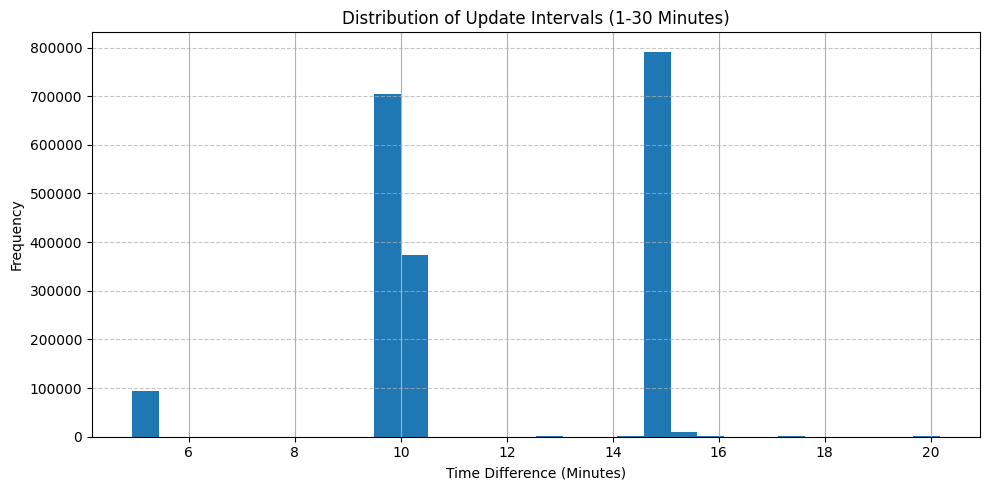


Median update interval: 10.02 minutes (Expected: 5 minutes).
Median interval differs significantly from the expected 5 minutes.


In [7]:
# --- 3. Analyze Update Frequency ---
if not df_traffic.empty and 'ID_TRAM' in df_traffic.columns and 'Timestamp' in df_traffic.columns:
    print("\n--- Analysis of Update Frequency ---")
    
    # Sort data first to ensure correct diff calculation within groups
    print("Sorting data by ID_TRAM and Timestamp...")
    df_traffic.sort_values(by=['ID_TRAM', 'Timestamp'], inplace=True)
    
    # Calculate time difference between consecutive readings for each tram
    print("Calculating time differences...")
    df_traffic['TimeDiff'] = df_traffic.groupby('ID_TRAM')['Timestamp'].diff()
    
    # Convert timediff to minutes for easier interpretation
    df_traffic['TimeDiff_Minutes'] = df_traffic['TimeDiff'].dt.total_seconds() / 60.0

    print("\n--- Summary Statistics for Time Differences (Minutes) ---")
    # Describe non-null differences
    time_diff_stats = df_traffic['TimeDiff_Minutes'].dropna().describe()
    print(time_diff_stats)
    
    # Check the most common time differences
    print("\n--- Most Common Time Differences (Minutes) ---")
    # Calculate counts, dropna, convert index to float for sensible sorting, sort by index
    common_diffs = df_traffic['TimeDiff_Minutes'].value_counts(dropna=True)
    common_diffs.index = common_diffs.index.astype(float)
    print(common_diffs.sort_index().head(10)) # Show top 10 most frequent intervals

    # Plot distribution of time differences (focus on common range, e.g., 0-30 mins)
    print("\nPlotting Distribution of Time Differences (0-30 Minutes):")
    try:
        plt.figure(figsize=(10, 5))
        df_traffic[
            (df_traffic['TimeDiff_Minutes'] > 0) & (df_traffic['TimeDiff_Minutes'] <= 30) 
        ]['TimeDiff_Minutes'].hist(bins=30) # Histogram for intervals up to 30 mins
        plt.title('Distribution of Update Intervals (1-30 Minutes)')
        plt.xlabel('Time Difference (Minutes)')
        plt.ylabel('Frequency')
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"Could not plot time difference distribution: {e}")
        
    expected_interval = 5 # minutes
    median_diff = time_diff_stats.get('50%') # Get median from describe()
    if median_diff is not None:
         print(f"\nMedian update interval: {median_diff:.2f} minutes (Expected: {expected_interval} minutes).")
         if abs(median_diff - expected_interval) < 1:
              print("Median interval is close to the expected 5 minutes.")
         else:
              print("Median interval differs significantly from the expected 5 minutes.")
    else:
        print("\nCould not calculate median update interval.")
        
    # Clean up temporary columns if desired
    # df_traffic.drop(columns=['TimeDiff', 'TimeDiff_Minutes'], inplace=True)

else:
    print("\nSkipping Update Frequency analysis: DataFrame empty or columns missing.")
